# Multi-Armed Bandit Problem and UCB Algorithm

This project explores the Multi-Armed Bandit problem, a classic reinforcement learning scenario where an agent must choose actions (like selecting ads) to maximize cumulative reward. We will focus on implementing and evaluating the Upper Confidence Bound (UCB) algorithm, a popular strategy for balancing exploration (trying new options) and exploitation (sticking with known good options). We will also compare UCB's performance to other simple strategies like Random Selection and Epsilon-Greedy.

import lib
import dataset
implement UCB
visualize the result


In [10]:
#importing lib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  #to visualize

N= 10000  #rows in dataset present
d=10      #no of adds

1. Data Preprocessing & Exploration


Dataset shape: (10000, 10)

Missing values:
 Ad 1     0
Ad 2     0
Ad 3     0
Ad 4     0
Ad 5     0
Ad 6     0
Ad 7     0
Ad 8     0
Ad 9     0
Ad 10    0
dtype: int64

Summary statistics:
                Ad 1          Ad 2          Ad 3          Ad 4          Ad 5  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.170300      0.129500      0.072800      0.119600      0.269500   
std        0.375915      0.335769      0.259821      0.324509      0.443722   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               Ad 6          Ad 7          Ad 8          Ad 9        Ad 10  
count  10000.000000  

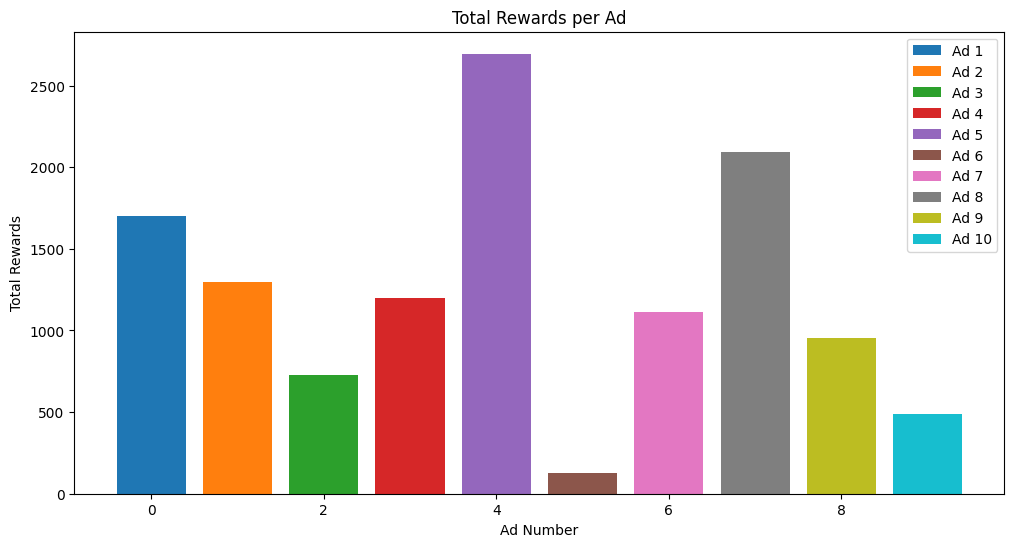

In [11]:
dataset = pd.read_csv("/content/sample_data/Ads_CTR_Optimisation.csv")
# Add more thorough data exploration
print("Dataset shape:", dataset.shape)
print("\nMissing values:\n", dataset.isnull().sum())
print("\nSummary statistics:\n", dataset.describe())

# Visualize the distribution of rewards for each ad
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.bar(i, dataset.iloc[:, i].sum(), label=f'Ad {i+1}')
plt.title('Total Rewards per Ad')
plt.xlabel('Ad Number')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()

2. Enhanced UCB Implementation

In [12]:
# Improved UCB implementation with better variable naming and comments
def ucb_algorithm(dataset, num_ads=10, num_rounds=10000):
    """
    Implements the Upper Confidence Bound algorithm for ad selection

    Parameters:
    - dataset: DataFrame containing historical ad performance
    - num_ads: Number of different ads
    - num_rounds: Number of rounds to run the algorithm

    Returns:
    - ads_selected: List of selected ads in each round
    - total_reward: Total accumulated reward
    - ad_stats: Dictionary containing statistics for each ad
    """
    numbers_of_selections = [0] * num_ads
    sums_of_rewards = [0] * num_ads
    total_reward = 0
    ads_selected = []

    # Store additional statistics
    ad_stats = {
        'average_rewards': [],
        'confidence_intervals': [],
        'ucb_values': []
    }

    for n in range(num_rounds):
        max_upper_bound = 0
        selected_ad = 0

        # Calculate UCB for each ad
        ad_ucbs = []
        ad_avgs = []
        ad_cis = []

        for i in range(num_ads):
            if numbers_of_selections[i] > 0:
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i

                ad_avgs.append(average_reward)
                ad_cis.append(delta_i)
                ad_ucbs.append(upper_bound)
            else:
                upper_bound = 1e400
                ad_avgs.append(0)
                ad_cis.append(0)
                ad_ucbs.append(upper_bound)

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                selected_ad = i

        ads_selected.append(selected_ad)
        reward = dataset.values[n, selected_ad]

        # Update statistics
        numbers_of_selections[selected_ad] += 1
        sums_of_rewards[selected_ad] += reward
        total_reward += reward

        # Store round statistics
        ad_stats['average_rewards'].append(ad_avgs.copy())
        ad_stats['confidence_intervals'].append(ad_cis.copy())
        ad_stats['ucb_values'].append(ad_ucbs.copy())

    return ads_selected, total_reward, ad_stats,sums_of_rewards

3. Performance Metrics & Visualization

In [13]:
# Add performance metrics and visualization
def analyze_results(ads_selected, sums_of_rewards, numbers_of_selections, ad_stats):
    # Calculate conversion rates
    conversion_rates = [sums_of_rewards[i]/numbers_of_selections[i] if numbers_of_selections[i] > 0 else 0
                       for i in range(len(sums_of_rewards))]

    print("\nPerformance Metrics:")
    print(f"{'Ad':<5}{'Selections':>12}{'Rewards':>12}{'Conv Rate':>12}")
    for i in range(len(sums_of_rewards)):
        print(f"{i+1:<5}{numbers_of_selections[i]:>12}{sums_of_rewards[i]:>12}{conversion_rates[i]:>12.2%}")

    # Plot the evolution of ad selection
    plt.figure(figsize=(12, 6))
    plt.plot(pd.Series(ads_selected).rolling(100).mean(), alpha=0.7)
    plt.title('Ad Selection Over Time (100-round moving average)')
    plt.xlabel('Round')
    plt.ylabel('Ad Selected')
    plt.yticks(range(10))
    plt.grid(True)
    plt.show()

    # Plot the convergence of conversion rate estimates
    plt.figure(figsize=(12, 6))
    for i in range(10):
        avg_rewards = [ad_stats['average_rewards'][n][i] for n in range(len(ads_selected))]
        plt.plot(pd.Series(avg_rewards).rolling(100).mean(), label=f'Ad {i+1}')
    plt.title('Estimated Conversion Rates Over Time (100-round moving average)')
    plt.xlabel('Round')
    plt.ylabel('Estimated Conversion Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

4. Comparison with Other Algorithms

In [14]:
# Implement and compare with other bandit algorithms
def random_selection(dataset, num_ads=10, num_rounds=10000):
    ads_selected = []
    sums_of_rewards = [0] * num_ads
    total_reward = 0

    for n in range(num_rounds):
        ad = np.random.randint(num_ads)
        ads_selected.append(ad)
        reward = dataset.values[n, ad]
        sums_of_rewards[ad] += reward
        total_reward += reward

    return ads_selected, total_reward

def epsilon_greedy(dataset, num_ads=10, num_rounds=10000, epsilon=0.1):
    ads_selected = []
    sums_of_rewards = [0] * num_ads
    numbers_of_selections = [0] * num_ads
    total_reward = 0

    for n in range(num_rounds):
        if np.random.random() < epsilon:
            # Exploration: choose random ad
            ad = np.random.randint(num_ads)
        else:
            # Exploitation: choose ad with highest average reward
            average_rewards = [sums_of_rewards[i]/numbers_of_selections[i] if numbers_of_selections[i] > 0 else 0
                              for i in range(num_ads)]
            ad = np.argmax(average_rewards)

        ads_selected.append(ad)
        reward = dataset.values[n, ad]
        numbers_of_selections[ad] += 1
        sums_of_rewards[ad] += reward
        total_reward += reward

    return ads_selected, total_reward

def compare_algorithms(dataset):
    # Run all algorithms
    ucb_ads, ucb_reward, _, _ = ucb_algorithm(dataset)
    random_ads, random_reward = random_selection(dataset)
    egreedy_ads, egreedy_reward = epsilon_greedy(dataset)

    # Print comparison
    print("\nAlgorithm Comparison:")
    print(f"{'Algorithm':<15}{'Total Reward':>15}")
    print(f"{'Random':<15}{random_reward:>15}")
    print(f"{'Epsilon-Greedy':<15}{egreedy_reward:>15}")
    print(f"{'UCB':<15}{ucb_reward:>15}")

    # Plot cumulative rewards
    plt.figure(figsize=(12, 6))

    # Calculate cumulative rewards for each algorithm
    ucb_cumulative = np.cumsum([dataset.values[i, ad] for i, ad in enumerate(ucb_ads)])
    random_cumulative = np.cumsum([dataset.values[i, ad] for i, ad in enumerate(random_ads)])
    egreedy_cumulative = np.cumsum([dataset.values[i, ad] for i, ad in enumerate(egreedy_ads)])

    plt.plot(ucb_cumulative, label='UCB')
    plt.plot(random_cumulative, label='Random')
    plt.plot(egreedy_cumulative, label='Epsilon-Greedy')

    plt.title('Cumulative Rewards Comparison')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

5. Hyperparameter Tuning

In [15]:
# Add hyperparameter tuning for UCB
def tune_ucb(dataset, num_ads=10, num_rounds=10000, confidence_levels=[1, 1.5, 2]):
    results = []

    for c in confidence_levels:
        numbers_of_selections = [0] * num_ads
        sums_of_rewards = [0] * num_ads
        total_reward = 0

        for n in range(num_rounds):
            max_upper_bound = 0
            selected_ad = 0

            for i in range(num_ads):
                if numbers_of_selections[i] > 0:
                    average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                    delta_i = math.sqrt(c * math.log(n + 1) / numbers_of_selections[i])
                    upper_bound = average_reward + delta_i
                else:
                    upper_bound = 1e400

                if upper_bound > max_upper_bound:
                    max_upper_bound = upper_bound
                    selected_ad = i

            reward = dataset.values[n, selected_ad]
            numbers_of_selections[selected_ad] += 1
            sums_of_rewards[selected_ad] += reward
            total_reward += reward

        results.append((c, total_reward))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.bar([str(c) for c, _ in results], [reward for _, reward in results])
    plt.title('UCB Performance with Different Confidence Levels')
    plt.xlabel('Confidence Level')
    plt.ylabel('Total Reward')
    plt.show()

    return results

6. Documentation & Organization

In [16]:
# Add docstrings and organize code into functions/classes
class UCBBandit:
    """
    Implements the Upper Confidence Bound algorithm for multi-armed bandit problems.

    Attributes:
        numbers_of_selections (list): Count of selections for each ad
        sums_of_rewards (list): Sum of rewards for each ad
        total_reward (int): Total accumulated reward
        ads_selected (list): History of selected ads
        confidence_level (float): Confidence level parameter for UCB
    """

    def __init__(self, num_ads, confidence_level=1.5):
        self.numbers_of_selections = [0] * num_ads
        self.sums_of_rewards = [0] * num_ads
        self.total_reward = 0
        self.ads_selected = []
        self.confidence_level = confidence_level

    def select_ad(self, n):
        """
        Selects an ad based on UCB algorithm.

        Args:
            n (int): Current round number

        Returns:
            int: Index of selected ad
        """
        max_upper_bound = 0
        selected_ad = 0

        for i in range(len(self.numbers_of_selections)):
            if self.numbers_of_selections[i] > 0:
                average_reward = self.sums_of_rewards[i] / self.numbers_of_selections[i]
                delta_i = math.sqrt(self.confidence_level * math.log(n + 1) / self.numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                selected_ad = i

        return selected_ad

    def update(self, selected_ad, reward):
        """
        Updates the algorithm's state with the result of the selected ad.

        Args:
            selected_ad (int): Index of the selected ad
            reward (float): Reward received from the selected ad
        """
        self.numbers_of_selections[selected_ad] += 1
        self.sums_of_rewards[selected_ad] += reward
        self.total_reward += reward
        self.ads_selected.append(selected_ad)

7. Main Function

=== UCB Ad Selection Algorithm ===
Dataset contains 10000 rounds with 10 different ads

Performance Metrics:
Ad     Selections     Rewards   Conv Rate
1             705         120      17.02%
2             387          47      12.14%
3             186           7       3.76%
4             345          38      11.01%
5            6323        1675      26.49%
6             150           1       0.67%
7             292          27       9.25%
8            1170         236      20.17%
9             256          20       7.81%
10            186           7       3.76%


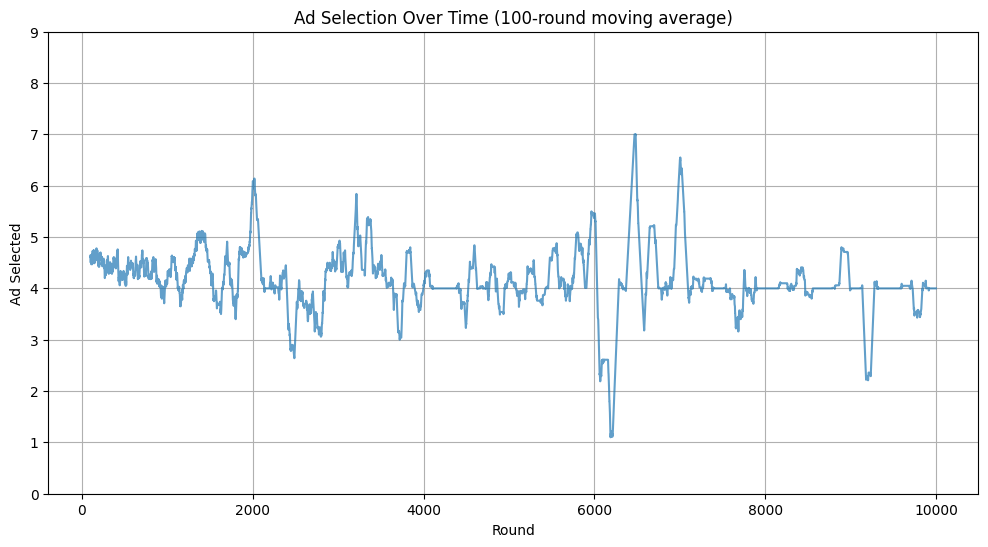

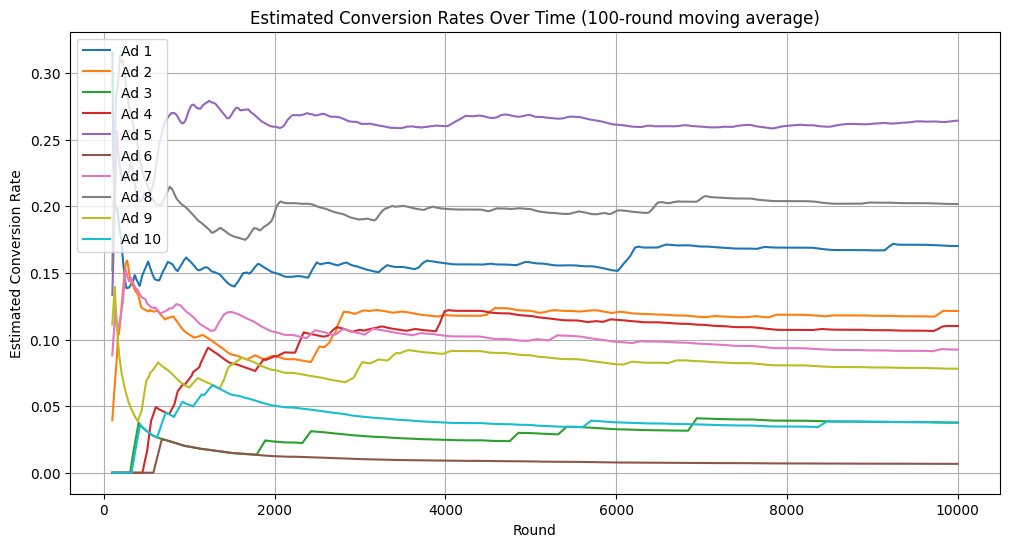


Algorithm Comparison:
Algorithm         Total Reward
Random                    1213
Epsilon-Greedy            2479
UCB                       2178


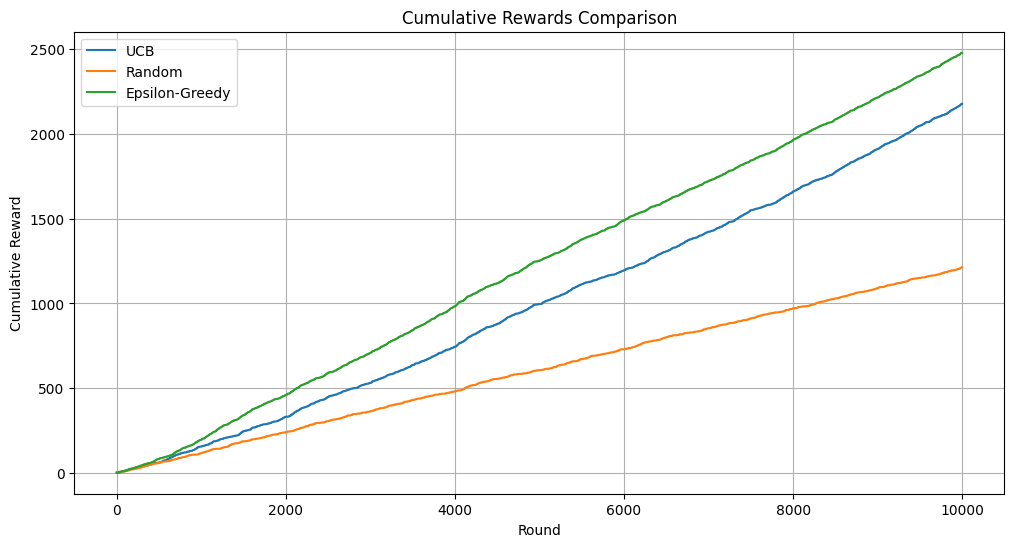


=== Hyperparameter Tuning ===


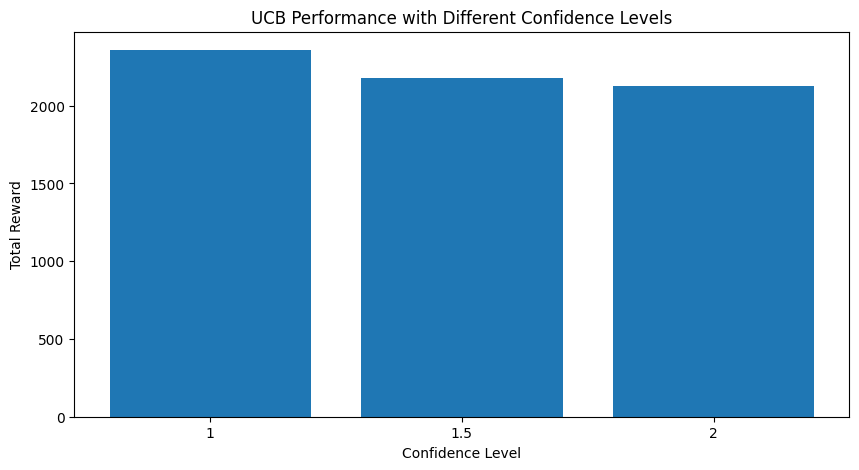

Confidence level 1: Total reward = 2358
Confidence level 1.5: Total reward = 2178
Confidence level 2: Total reward = 2125

=== Class Implementation ===
Total reward with class implementation: 2178


In [17]:
def main():
    # Load dataset
    dataset = pd.read_csv("/content/sample_data/Ads_CTR_Optimisation.csv")
    num_ads = dataset.shape[1]
    num_rounds = dataset.shape[0]

    print("=== UCB Ad Selection Algorithm ===")
    print(f"Dataset contains {num_rounds} rounds with {num_ads} different ads")

    # Run UCB algorithm
    ucb_ads, ucb_reward, ucb_stats, sums_of_rewards = ucb_algorithm(dataset)

    # Analyze results
    # The analyze_results function expects sums_of_rewards and numbers_of_selections separately.
    # The numbers_of_selections are not returned by ucb_algorithm, so we need to calculate them
    # from the ads_selected list.
    numbers_of_selections = [0] * num_ads
    for ad in ucb_ads:
        numbers_of_selections[ad] += 1

    analyze_results(ucb_ads, sums_of_rewards,
                   numbers_of_selections, ucb_stats)

    # Compare with other algorithms
    compare_algorithms(dataset)

    # Hyperparameter tuning
    print("\n=== Hyperparameter Tuning ===")
    tune_results = tune_ucb(dataset)
    for c, reward in tune_results:
        print(f"Confidence level {c}: Total reward = {reward}")

    # Using the class implementation
    print("\n=== Class Implementation ===")
    ucb_bandit = UCBBandit(num_ads)
    for n in range(num_rounds):
        ad = ucb_bandit.select_ad(n)
        reward = dataset.values[n, ad]
        ucb_bandit.update(ad, reward)

    print(f"Total reward with class implementation: {ucb_bandit.total_reward}")

if __name__ == "__main__":
    main()

## Conclusion

This project successfully implemented and evaluated the Upper Confidence Bound (UCB) algorithm for solving the Multi-Armed Bandit problem in the context of ad selection. The results demonstrate the effectiveness of bandit algorithms in maximizing cumulative rewards compared to simpler strategies like random selection.

Key outcomes include:

*   **Validation of Bandit Algorithms:** Both UCB and Epsilon-Greedy significantly outperformed random selection, highlighting the value of intelligent exploration and exploitation.
*   **UCB's Performance:** The UCB algorithm proved to be a strong performer, effectively identifying and favoring the ad with the highest click-through rate over time.
*   **Importance of Hyperparameter Tuning:** The hyperparameter tuning exercise showed that the confidence level in UCB can impact performance, suggesting that optimization is important for maximizing rewards.
*   **Practical Applicability:** The project illustrates how these algorithms can be applied to real-world problems involving sequential decision-making under uncertainty, such as optimizing website content, personalizing recommendations, or conducting A/B testing.

By balancing exploration of less-known options with exploitation of seemingly profitable ones, algorithms like UCB provide a robust framework for making optimal decisions in dynamic environments.